In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import matplotlib.pyplot as plt

In [28]:
from keras.models import Model, load_model
from keras.layers import multiply, Lambda, add, Activation, Dropout, Conv2DTranspose, ReLU, ZeroPadding2D, BatchNormalization, Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU, MaxPooling2D, UpSampling2D, Concatenate, concatenate
from keras.optimizers import Adam
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf
from scipy.signal import lfilter, wiener
import scipy

from pesq import pesq
import pystoi

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance
import librosa
from tqdm import tqdm

from sound import Sound

from IPython.display import Audio
import time
from IPython import display
from batch import DataGenerator
import pandas as pd

In [5]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
base_shape_size = 8192
ws = 255
ol = 128

In [7]:
sound_base = Sound('../Dados/Base/', '../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:11<00:00, 180.33it/s]


In [8]:
def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    stft_result = librosa.stft(signal, n_fft=window_size, hop_length=overlap)
    
    magnitude, phase = librosa.magphase(stft_result)
    phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(stft_result.shape[1]), sr=sampling_rate, hop_length=overlap)

    return magnitude, phi, f, t

def reconstruct_signal_from_stft(magnitude, phi, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    complex_spec = magnitude * np.exp(1j * phi)
    signal = librosa.istft(complex_spec, hop_length=overlap)

    return signal

In [9]:
def lpc_analysis(signal, order):
    windowed_signal = signal * np.hanning(len(signal))

    a = librosa.lpc(windowed_signal, order=order)

    b = np.hstack([[0], -1 * a[1:]])
    y_hat = scipy.signal.lfilter(b, [1], signal)

    var_residual = np.var(signal - y_hat)

    return a, np.sqrt(var_residual), 0

def build_matrices(A, window_size):
    Ak = np.zeros((order, order))
    Ak[:, 0] = -A[1:]
    Ak[:-1, 1:] = np.eye(order - 1)

    H = np.zeros((1, order))
    H[0, 0] = 1.0

    return Ak, H

def kalman_filter(signal, Ak, H, Q, R):
    x_hat = np.zeros(order)  # Estado estimado
    P = np.eye(order)  # Covariância estimada

    filtered_signal = []

    for sample in signal:
        # Atualização temporal (Predição)
        x_hat = np.dot(Ak, x_hat)
        P = np.dot(np.dot(Ak, P), Ak.T) + Q

        # Atualização de mensuração (Correção)
        K = np.dot(np.dot(P, H.T), np.linalg.inv(np.dot(np.dot(H, P), H.T) + R))
        x_hat = x_hat + np.dot(K, (sample - np.dot(H, x_hat)))
        P = P - np.dot(np.dot(K, H), P)

        filtered_signal.append(x_hat[0])  # Apenas a primeira componente é o sinal estimado

    return np.array(filtered_signal)

def kalman(signal, window_size, order, sample_rate, SNR_dB=10.):
    filtered_signal = []

    for i in range(0, len(signal), window_size):
        window_samples = signal[i:i+window_size]
        
        # Realizar análise LPC e construir as matrizes Ak e H
        A, sigma, _ = lpc_analysis(window_samples, order)
        Ak, H = build_matrices(A, len(window_samples))

        # Calcular a variância do erro de aquisição R com base no SNR linear
        SNR_linear = 10.**(SNR_dB / 10.)
        Rx = 1. / SNR_linear
        
        # Calcular Q e R (assumindo que não mudam dentro da janela)
        Q = np.eye(order) * sigma  # Variância do erro de predição
        R = np.eye(1) * Rx  # Variância do erro de aquisição

        # Aplicar o filtro de Kalman na janela
        filtered_window = kalman_filter(window_samples, Ak, H, Q, R)
        filtered_signal.extend(filtered_window)

    return np.array(filtered_signal)

In [10]:
def wiener_filter(noisy_signal, snr_db):
    """
    Aplica o filtro de Wiener para remover ruído de um sinal ruidoso.

    Args:
        noisy_signal (numpy array): O sinal de voz ruidoso.
        snr_db (float): Relação sinal-ruído (SNR) desejada em dB.

    Returns:
        filtered_signal (numpy array): O sinal filtrado.
    """
    # Calcule a potência do sinal ruidoso
    signal_power = np.mean(noisy_signal ** 2)

    # Calcule a potência do ruído com base na relação sinal-ruído desejada em dB
    noise_power = signal_power / (10 ** (snr_db / 10))

    filtered_signal = wiener(noisy_signal.astype('float32'), mysize=10)

    return filtered_signal

In [74]:
batch_num = 1
window_size = 250
order = 11
df_resultado = pd.DataFrame()

In [75]:
data_generator = DataGenerator(sound_base.train_X, sound_base.noise_sounds)

In [76]:
x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_metrics(window_size, order, batch_size=1))
# Aplica o filtro de Wiener aos sinais ruidosos
filtered_wiener = [wiener_filter(noisy_signal, snr) for noisy_signal, snr in zip(x_batch, metrics_batch_df['SNR'])]

# Calcula as métricas para os sinais filtrados
pesq_scores = [pesq(8000, clean, filtered.reshape(-1), 'nb') for clean, filtered in zip(y_batch, filtered_winer)]
stoi_scores = [pystoi.stoi(clean, filtered, 8000) for clean, filtered in zip(y_batch, filtered_winer)]
snr_scores = [calculate_snr(clean, filtered) for clean, filtered in zip(y_batch, filtered_winer)]
ID_scores = [itakura_distortion(clean, filtered, window_size, order) for clean, filtered in zip(y_batch, filtered_winer)]

# Adiciona as métricas dos sinais filtrados ao DataFrame
metrics_batch_df['PESQ (Filtered - Winer)'] = pesq_scores
metrics_batch_df['STOI (Filtered) - Winer'] = stoi_scores
metrics_batch_df['SNR (Filtered) - Winer'] = snr_scores
metrics_batch_df['ID (Filtered - Winer)'] = ID_scores

df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)


In [77]:
SNR_dB_batch = metrics_batch_df['SNR']

filtered_kalman = [kalman(noisy_signal, window_size, order, 8000, SNR_dB=SNR_dB) for noisy_signal, SNR_dB in zip(x_batch, SNR_dB_batch)]

# Calcula as métricas para os sinais filtrados
pesq_scores = [pesq(8000, clean, filtered.reshape(-1), 'nb') for clean, filtered in zip(y_batch, filtered_kalman)]
stoi_scores = [pystoi.stoi(clean, filtered, 8000) for clean, filtered in zip(y_batch, filtered_kalman)]
snr_scores = [calculate_snr(clean, filtered) for clean, filtered in zip(y_batch, filtered_kalman)]
ID_scores = [itakura_distortion(clean, filtered, window_size, order) for clean, filtered in zip(y_batch, filtered_kalman)]

# Adiciona as métricas dos sinais filtrados ao DataFrame
metrics_batch_df['PESQ (Filtered - Kalman)'] = pesq_scores
metrics_batch_df['STOI (Filtered) - Kalman'] = stoi_scores
metrics_batch_df['SNR (Filtered) - Kalman'] = snr_scores
metrics_batch_df['ID (Filtered) - Kalman'] = ID_scores

df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

In [78]:
df_resultado

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered - Winer),STOI (Filtered) - Winer,SNR (Filtered) - Winer,ID (Filtered - Winer),PESQ (Filtered - Kalman),STOI (Filtered) - Kalman,SNR (Filtered) - Kalman,ID (Filtered) - Kalman
0,0.0,18.0,1.478573,0.849472,-0.118688,0.344954,1.073971,0.249313,-1.349611,0.024251,NaN,NaN,NaN,NaN
1,0.0,18.0,1.478573,0.849472,-0.118688,0.344954,1.073971,0.249313,-1.349611,0.024251,1.467393,0.828533,0.063223,0.431427


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


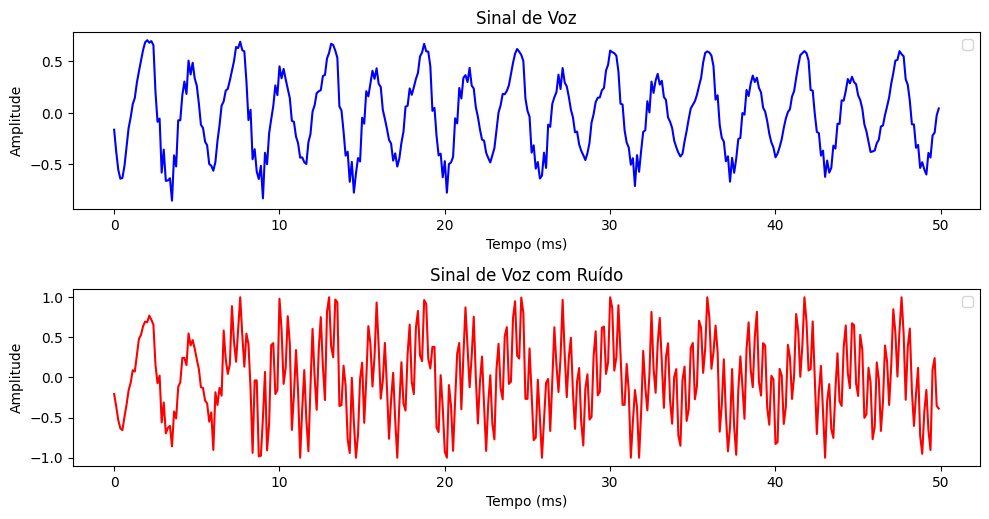

In [88]:
index = 0
start = 2800
step = 400
end = start + step

sample_rate = 8000

# Intervalo de tempo entre amostras em segundos
time_interval = 1 / sample_rate
# Vetor de tempo em milissegundos
time_ms = np.arange(0, step) * time_interval * 1000

# Plote o sinal original e o sinal do LPC gerado
plt.figure(figsize=(10, 10))

# Plote o sinal original
plt.subplot(4, 1, 1)
plt.plot(time_ms, y_batch[index][start:end], color='blue')
plt.title('Sinal de Voz')
plt.xlabel('Tempo (ms)')
plt.ylabel('Amplitude')
plt.legend()

# Plote o sinal do LPC gerado
plt.subplot(4, 1, 2)
plt.plot(time_ms, x_batch[index][start:end], color='red')
plt.title('Sinal de Voz com Ruído')
plt.xlabel('Tempo (ms)')
plt.ylabel('Amplitude')
plt.legend()

# # Plote o sinal do LPC gerado
# plt.subplot(4, 1, 3)
# plt.plot(filtered_wiener[index][start:end], label='Sinal Filtrado - Wiener', color='green')
# plt.title('Sinal Filtrado')
# plt.xlabel('Amostras')
# plt.ylabel('Amplitude')
# plt.legend()

# # Plote o sinal do LPC gerado
# plt.subplot(4, 1, 4)
# plt.plot(filtered_kalman[index][start:end], label='Sinal Filtrado - Kalman', color='magenta')
# plt.title('Sinal Filtrado')
# plt.xlabel('Amostras')
# plt.ylabel('Amplitude')
# plt.legend()

plt.tight_layout()
plt.show()

In [83]:
Audio(data=y_batch[index][start:end], rate=8000)

In [89]:
Audio(data=x_batch, rate=8000)